# Part 1: Instalasi dan Import Library

In [ ]:
!pip install scikit-image --upgrade

In [ ]:
!pip install opencv-python-headless scikit-image scikit-learn matplotlib pillow

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
from google.colab import files, drive
from skimage.filters import threshold_multiotsu
from skimage.morphology import remove_small_objects
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

# Part 2: Mount Google Drive

In [ ]:
from google.colab import drive # Import the 'drive' object from the 'google.colab' module

drive.mount('/content/drive')

# Konfigurasi Path
images_path = '/content/drive/MyDrive/DRIVE_dataset/test/images'
masks_path = '/content/drive/MyDrive/DRIVE_dataset/test/masks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 3: Fungsi Pembacaan Dataset

In [ ]:
def load_dataset(images_path, masks_path):
    images = []
    masks = []
    filenames = []

    print("Loading DRIVE dataset...")
    for img_name in sorted(os.listdir(images_path)):
        if img_name.endswith('.tif'):
            # Load image
            img_path = os.path.join(images_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (256, 256))
            images.append(img)

            # Load corresponding mask using Pillow
            mask_name = img_name.replace('.tif', '.gif')
            mask_path = os.path.join(masks_path, mask_name)
            try:
                mask = Image.open(mask_path).convert('L') # Convert to grayscale
                mask = np.array(mask)
                mask = cv2.resize(mask, (256, 256))
                _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
                masks.append(mask)
            except Exception as e:
                print(f"Warning: Failed to load mask {mask_path} due to error: {e}. Skipping.")
                masks.append(np.zeros_like(img[:, :, 0], dtype=np.uint8)) # Placeholder if mask loading fails


            # Check if the mask file exists before attempting to load it
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                # Check if the mask was loaded successfully before resizing
                if mask is not None:
                    mask = cv2.resize(mask, (256, 256))
                    # Binarize mask
                    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
                    masks.append(mask)
                else:
                    print(f"Warning: Failed to load mask {mask_path}. Skipping.")
                    # Consider adding a placeholder for the mask to keep the lengths consistent
                    masks.append(np.zeros_like(img[:, :, 0], dtype=np.uint8)) # Placeholder if mask loading fails
            else:
                print(f"Warning: Mask file {mask_path} not found. Skipping.")
                # Consider adding a placeholder for the mask to keep the lengths consistent
                masks.append(np.zeros_like(img[:, :, 0], dtype=np.uint8)) # Placeholder if mask file not found

            filenames.append(img_name)

    return np.array(images), np.array(masks), filenames

# Part 4: Preprocessing Green Channel

In [ ]:
def preprocess_green_channel(image):
    # Extract green channel
    green_channel = image[:,:,1]

    # Visualisasi Green Channel
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(132)
    plt.title('Green Channel')
    plt.imshow(green_channel, cmap='gray')
    plt.axis('off')

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    green_clahe = clahe.apply(green_channel)

    plt.subplot(133)
    plt.title('Green Channel CLAHE')
    plt.imshow(green_clahe, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Convert to 8-bit
    green_8bit = cv2.normalize(green_clahe, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return green_8bit


# Part 5: Laplacian of Gaussian

In [ ]:
def apply_laplacian_of_gaussian(green_8bit):
    # Laplacian of Gaussian
    sigma = 0.8
    log = cv2.GaussianBlur(green_8bit, (0, 0), sigma)
    log = cv2.Laplacian(log, cv2.CV_8U)

    # Visualisasi
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title('Green Channel 8-bit')
    plt.imshow(green_8bit, cmap='gray')
    plt.axis('off')

    plt.subplot(132)
    plt.title('Gaussian Blur')
    gaussian_blur = cv2.GaussianBlur(green_8bit, (0, 0), sigma)
    plt.imshow(gaussian_blur, cmap='gray')
    plt.axis('off')

    plt.subplot(133)
    plt.title('Laplacian of Gaussian')
    plt.imshow(log, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return log

# Part 6: Segmentasi dengan Otsu Thresholding

In [ ]:
def segment_with_otsu_enhanced(log_image, manual_adjust=103):
    # Meningkatkan kontras
    equalized_image = cv2.equalizeHist(log_image)

    # Otsu thresholding dengan penyesuaian manual
    _, otsu_thresh = cv2.threshold(equalized_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Ensure otsu_thresh is a scalar by taking its mean
    adjusted_thresh = int(otsu_thresh.mean()) + manual_adjust # Convert to integer

    _, binary = cv2.threshold(equalized_image, adjusted_thresh, 255, cv2.THRESH_BINARY)

    # Morphological closing untuk memperbesar area putih
    kernel = np.ones((3, 3), np.uint8)
    binary_closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel) # Apply closing directly to 'binary'

    # Visualisasi
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title('Laplacian of Gaussian')
    plt.imshow(log_image, cmap='gray')
    plt.axis('off')

    plt.subplot(132)
    plt.title('Otsu Threshold (Adjusted)')
    plt.imshow(binary, cmap='gray')
    plt.axis('off')

    plt.subplot(133)
    plt.title('Binary Image After Closing')
    plt.imshow(binary_closed, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return binary_closed

# Part 7: Morfologi dan Area Opening

In [ ]:
# Part 7: Morfologi dan Area Opening
def apply_morphology(binary):
    h, w = binary.shape

    # Remove border artifacts
    border_mask = np.zeros((h, w), dtype=np.uint8)
    border_mask[1:-1, 1:-1] = 255
    binary = cv2.bitwise_and(binary, binary, mask=border_mask)

    # Area opening with pixel number
    area_threshold = max(6, int(h * w * 0.0001))
    binary = remove_small_objects(binary.astype(bool), min_size=area_threshold)
    binary = binary.astype(np.uint8) * 255

    # Visualisasi
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title('Original Binary')
    plt.imshow(binary, cmap='gray')
    plt.axis('off')

    plt.subplot(132)
    plt.title('After Border Removal')
    border_removed = cv2.bitwise_and(binary, binary, mask=border_mask)
    plt.imshow(border_removed, cmap='gray')
    plt.axis('off')

    plt.subplot(133)
    plt.title(f'After Area Opening (threshold: {area_threshold})')
    plt.imshow(binary, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return binary

# Part 8: Evaluasi dengan Ground Truth

Loading DRIVE dataset...


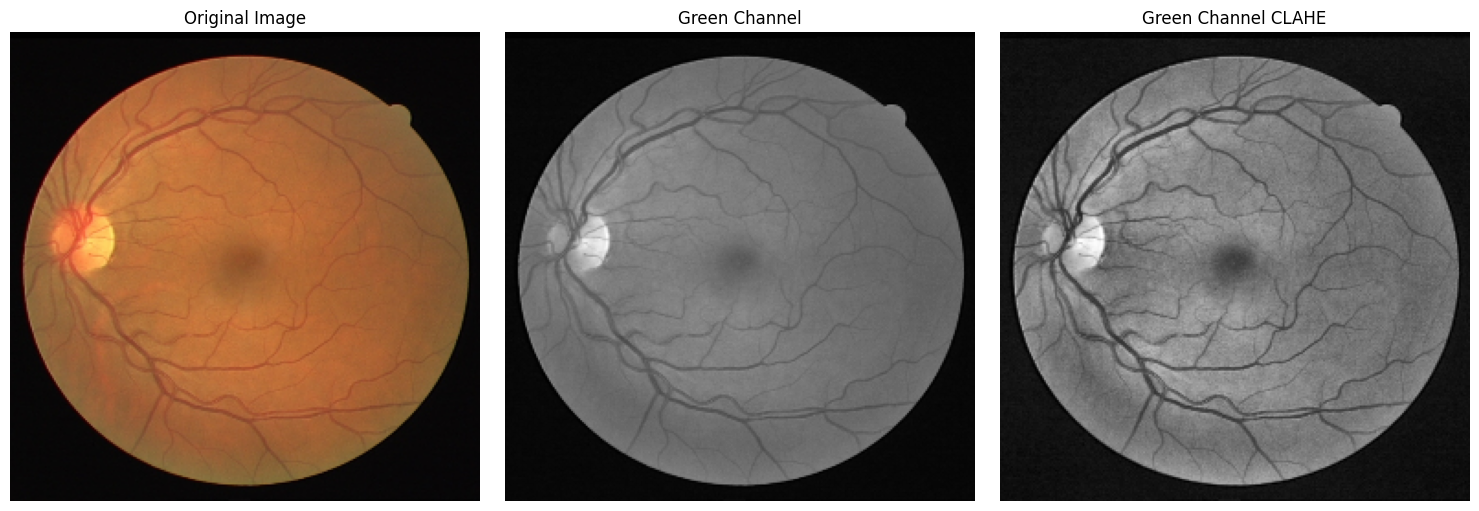

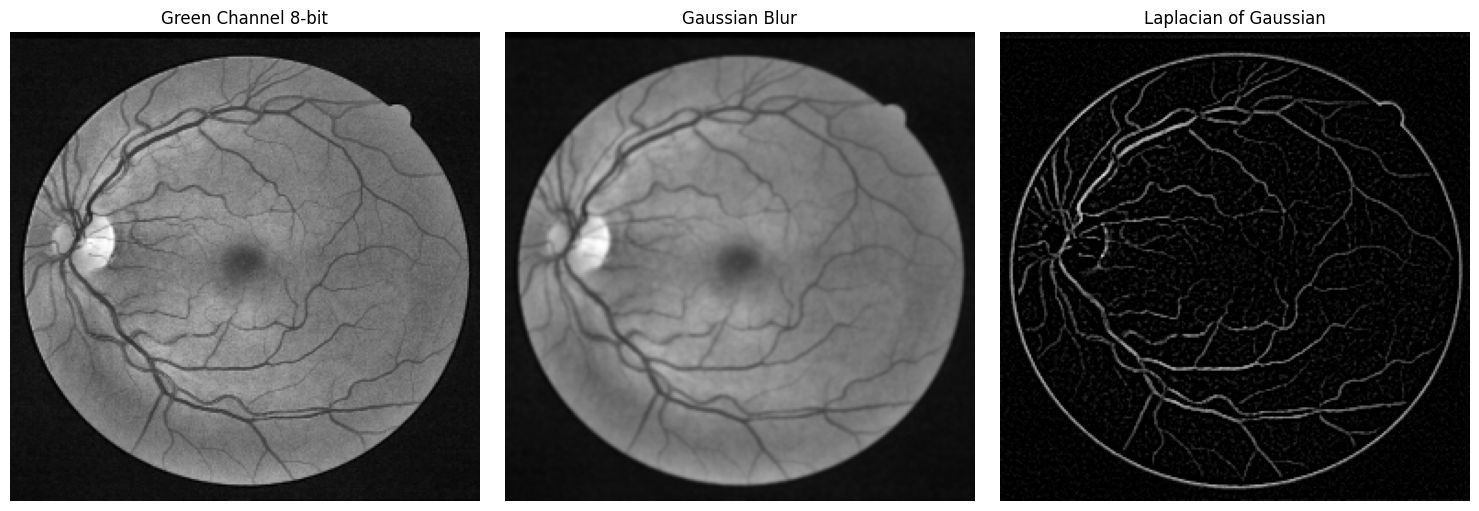

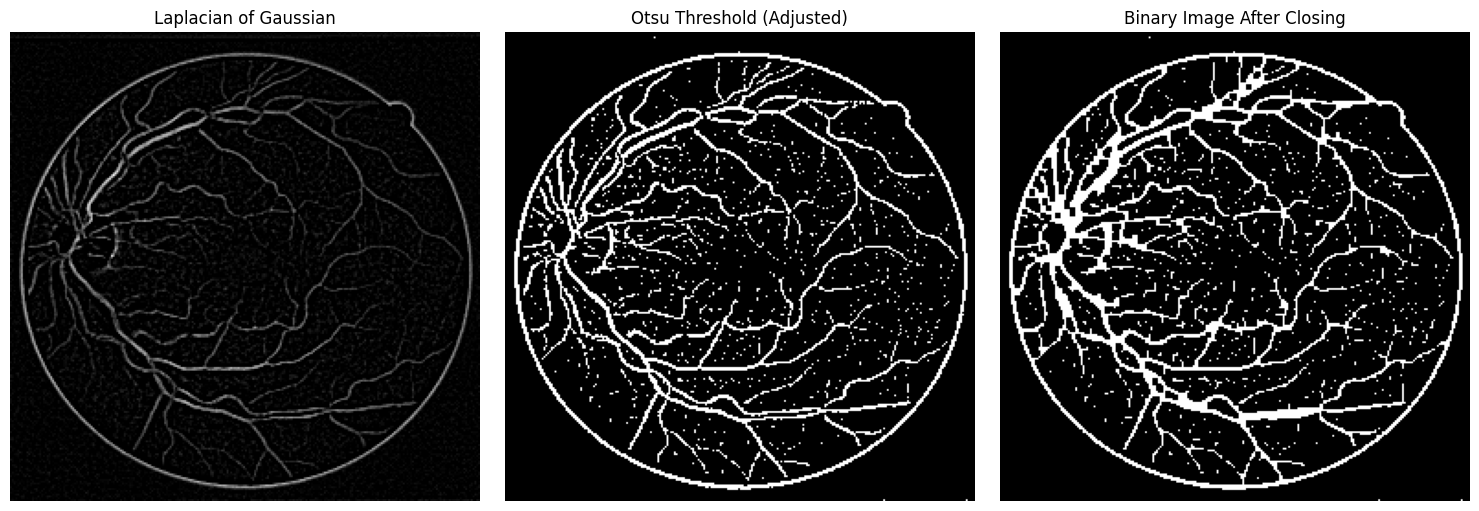

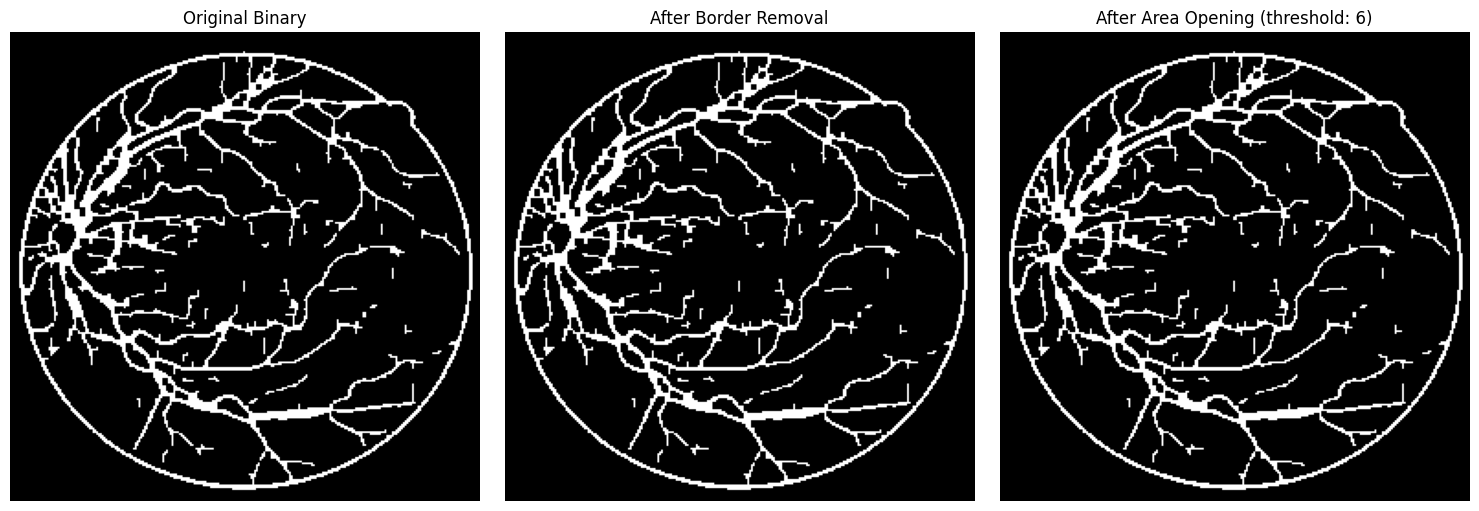

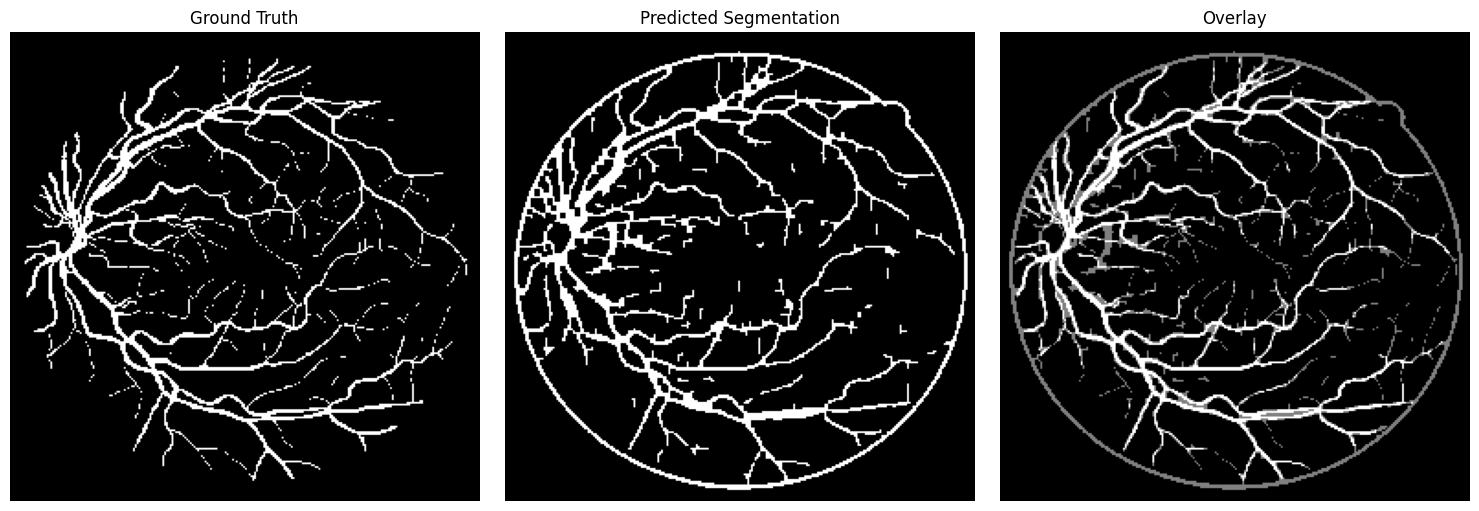


Metrics:
IoU: 0.4823
Precision: 0.5642
Recall: 0.7687
F1 Score: 0.6507


In [ ]:
def evaluate_segmentation(predicted, ground_truth):
    # Ensure both are binary (0 or 1)
    predicted_binary = (predicted > 0).astype(int)
    ground_truth_binary = (ground_truth > 0).astype(int)

    # Compute Intersection over Union (IoU)
    intersection = np.sum(np.logical_and(predicted_binary, ground_truth_binary))
    union = np.sum(np.logical_or(predicted_binary, ground_truth_binary))
    iou = intersection / union if union != 0 else 0.0

    # Compute other metrics
    metrics = {
        'IoU': iou,
        'Precision': precision_score(ground_truth_binary.flatten(), predicted_binary.flatten()),
        'Recall': recall_score(ground_truth_binary.flatten(), predicted_binary.flatten()),
        'F1 Score': f1_score(ground_truth_binary.flatten(), predicted_binary.flatten())
    }

    # Visualize results
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title('Ground Truth')
    plt.imshow(ground_truth, cmap='gray')
    plt.axis('off')

    plt.subplot(132)
    plt.title('Predicted Segmentation')
    plt.imshow(predicted, cmap='gray')
    plt.axis('off')

    plt.subplot(133)
    plt.title('Overlay')
    overlay = cv2.addWeighted(ground_truth/255, 0.5, predicted/255, 0.5, 0)
    plt.imshow(overlay, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return metrics

# Main Execution
# Load images and masks
images, masks, filenames = load_dataset(images_path, masks_path)

# Process the first image
image = images[0]
mask = masks[0]

# Step by Step
green_8bit = preprocess_green_channel(image)
log_image = apply_laplacian_of_gaussian(green_8bit)
binary = segment_with_otsu_enhanced(log_image)
segmented = apply_morphology(binary)
metrics = evaluate_segmentation(segmented, mask)

print("\nMetrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")
